# Wasserstein Gradient Penalty for MNIST Dataset & Financial Simulation on S&P500 Index

# Abstract:
In questo lavoro viene presentata l'implementazione e l'analisi di due Wasserstein Generative Adversarial Networks applicate a domini eterogenei. La prima architettura funge da sistema di riferimento per validare la stabilità del modello su un dataset consolidato quale MNIST. Successivamente, il framework viene adattato per modellare la dinamica stocastica dei log-rendimenti dell'indice S&P 500, con l'obiettivo di generare serie temporali sintetiche coerenti con il comportamento del mercato reale.

Per entrambe le implementazioni è stata adottata la variante Gradient Penalty, necessaria per imporre rigorosamente il vincolo di Lipschitzianità alla funzione del critico e garantire la convergenza del gradiente. La validazione sul dataset MNIST ha prodotto un Frechet Inception Distance score (FID Score) pari a 10.81, confermando l'efficacia del modello nell'apprendere correttamente la varietà topologica delle immagini.

Nella fase applicativa finanziaria, la fedeltà del generatore è stata valutata attraverso il confronto dei momenti statistici della distribuzione. I risultati sperimentali indicano una convergenza ottimale del primo e del secondo momento, con una corrispondenza quasi esatta della media e della varianza rispetto ai dati storici. Tuttavia, l'analisi dell'eccesso di curtosi evidenzia una discrepanza significativa, suggerendo la presenza di limiti strutturali del modello nel catturare pienamente la natura estrema e non stazionaria degli eventi caratteristici dei mercati finanziari.

## 1 Introduzione:
I Generative Adversarial Model rappresentano una delle frontiere più promettenti del Deep Learning per l'apprendimento non supervisionato di distribuzioni complesse. Tuttavia, le architetture tradizionali basate sulla minimizzazione della divergenza di Jensen-Shannon soffrono notoriamente di instabilità durante la fase di addestramento, manifestando problematiche quali il vanishing gradient e il mode collapse.

Per ovviare a tali limitazioni strutturali, in questo progetto è stata adottata l'architettura Wasserstein GAN (WGAN). Tale approccio ridefinisce la funzione obiettivo sfruttando la distanza di Wasserstein, una metrica che garantisce gradienti più stabili e significativi anche quando le distribuzioni dei dati reali e generati non presentano sovrapposizioni nel supporto. Nello specifico, è stata implementata la variante con Gradient Penalty, ritenuta lo stato dell'arte per imporre il vincolo di 1-Lipschitzianità necessario alla convergenza teorica del modello.

L'obiettivo primario di questa prima fase è validare la robustezza dell'architettura proposta su un dataset di benchmark controllato quale MNIST. La scelta di operare in un ambiente a bassa dimensionalità e topologicamente noto permette di verificare la capacità del modello di apprendere la varietà dei dati e di monitorare la stabilità della funzione di costo in condizioni ideali.

Infine, al fine di garantire la totale riproducibilità scientifica degli esperimenti e isolare l'efficacia dell'algoritmo dalla stocasticità dell'inizializzazione dei pesi, è stato fissato un random seed globale (pari a 16) per i generatori pseudo-casuali delle librerie TensorFlow[1] e NumPy[2].


## 2 Metodi:
### 2.1 Preparazione dei Dati:
Per la fase di validazione del modello è stato utilizzato il dataset MNIST[3], acquisito tramite la libreria Keras[4]. Tale dataset è composto da 70000 immagini in scala di grigio rappresentanti cifre scritte a mano, con una risoluzione di 28x28 pixel.

La procedura di preparazione dei dati ha previsto una normalizzazione preliminare dei valori dei pixel nell'intervallo $[-1, 1]$. Tale operazione risulta indispensabile per garantire la coerenza tra la distribuzione dei dati reali e l'output del generatore, il quale utilizza una funzione di attivazione $tanh$ nel suo strato terminale. Senza tale allineamento, il processo di ottimizzazione dei pesi risulterebbe inefficiente a causa della saturazione dei gradienti.

In conformità con le pratiche standard di deep learning, il dataset è stato suddiviso in due set indipendenti: un set di addestramento comprendente 60000 campioni, utilizzato per l'aggiornamento dei parametri della rete, e un set di test di 10000 campioni, riservato alla valutazione finale della capacità di generalizzazione del modello.


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random


tf.random.set_seed(16)
np.random.seed(16)
random.seed(16)

data=tf.keras.datasets.mnist.load_data()   #download MNIST dataset
(train_images,train_labels),(test_images,test_labels)=data    #convert all the data into 4 tuples

train_images=np.expand_dims(train_images,axis=-1)
train_images=train_images.astype('float32')
train_images=((train_images/255.0)*2)-1  #normalize the train images to the range [-1, 1]

test_images=np.expand_dims(test_images,axis=-1)
test_images=test_images.astype('float32')
test_images=((test_images/255.0)*2)-1  #normalize the test images to the range [-1, 1]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 2.2 Architettura
L'architettura implementata si fonda sul paradigma avversario, composto da due reti neurali distinte, il Generatore ($G$) e il Critico ($D$), ottimizzate per assolvere a funzioni obiettivo complementari. A differenza delle GAN tradizionali, il Discriminatore viene qui definito Critico poiché non restituisce una probabilità di appartenenza alle classi, bensì uno scalare reale non limitato che approssima la distanza di Wasserstein.

**Il Generatore**

La rete generatrice è progettata per mappare un vettore latente $z$ di dimensione 100, campionato da una distribuzione normale standard $\mathcal{N}(0, 1)$, nello spazio delle immagini target ($28 \times 28 \times 1$).
Strutturalmente, il modello impiega un approccio convoluzionale inverso. Il vettore $z$ viene inizialmente proiettato tramite uno strato Dense in un tensore di dimensioni $7 \times 7 \times 256$. Successivamente, vengono applicati due blocchi di Conv2DTranspose, che effettuano l'upsampling progressivo della mappa delle caratteristiche: da $7 \times 7$ a $14 \times 14$, fino alla dimensione finale di $28 \times 28$.
Per stabilizzare l'apprendimento, ogni strato intermedio utilizza la normalizzazione Batch Normalization e la funzione di attivazione LeakyReLU. Lo strato di output utilizza invece la funzione Tangente Iperbolica, garantendo che i valori dei pixel generati siano confinati nell'intervallo $[-1, 1]$, coerentemente con il pre-processamento dei dati reali.

**Il Critico**

Il Critico presenta una struttura convoluzionale gerarchica standard per l'estrazione delle caratteristiche. L'input è costituito da un'immagine $28 \times 28 \times 1$. La rete riduce progressivamente la dimensionalità spaziale attraverso due strati convoluzionali con stride 2, che comprimono l'immagine da $28 \times 28$ a $7 \times 7$, aumentando contemporaneamente la profondità dei filtri da 64 a 128.
Un aspetto cruciale dell'implementazione riguarda la normalizzazione: a differenza del Generatore, il Critico impiega la Layer Normalization. Tale scelta è imposta dal protocollo WGAN-GP, in quanto la Batch Normalization introdurrebbe dipendenze tra i campioni del batch che invaliderebbero il calcolo della penalità del gradiente sul singolo campione interpolato.
Dopo l'appiattimento del tensore grazie allo strato Flatten, i dati attraversano uno strato denso intermedio da 256 unità, con attivazione ReLU e Dropout per la regolarizzazione, per giungere allo strato finale denso a singola unità. Quest'ultimo è privo di funzione di attivazione, permettendo alla rete di restituire un punteggio non limitato, necessario per la stima della metrica di Wasserstein.


In [2]:

G=tf.keras.Sequential([
    tf.keras.layers.Dense(units=12544,input_shape=(100,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7,7,256)),
    tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=(3,3),padding="same",strides=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(3,3),activation="tanh",padding="same",strides=(2,2))
])

G.summary()

D=tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",strides=(2,2),input_shape=(28,28,1)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same",strides=(2,2)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256,activation="relu"),   #test, ho rimosso il drop out, controllare anche togliendo dense finale
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

D.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         1,153 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,613,825 (6.16 MB)

 Trainable params: 1,588,481 (6.06 MB)

 Non-trainable params: 25,344 (99.00 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 14, 14, 64)     │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 7, 7, 128)      │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,681,025 (6.41 MB)

 Trainable params: 1,681,025 (6.41 MB)

 Non-trainable params: 0 (0.00 B)

### 2.3 Addestramento e Funzione di Costo

L'obiettivo del Critico non è classificare i campioni come veri o falsi come nelle GAN classiche, bensì massimizzare la differenza tra il punteggio assegnato ai dati reali e quello assegnato ai dati generati, approssimando così la distanza di Wasserstein. Per il processo di training sono stati utilizzati i parametri del paper ufficiale delle WGAN-GP[5]

La funzione di costo per il Critico ($L_D$), che viene minimizzata durante il training, è definita come:

$$ L_D = \mathbb{E}_{\tilde{x} \sim P_g}[D(\tilde{x})] - \mathbb{E}_{x \sim P_r}[D(x)] + \lambda \mathbb{E}_{\hat{x}}[(||\nabla_{\hat{x}} D(\hat{x})||_2 - 1)^2] $$

Dove:
*   Il primo termine penalizza il punteggio alto sui dati generati ($\tilde{x}$).
*   Il secondo termine premia il punteggio alto sui dati reali ($x$).
*   Il terzo termine è la Gradient Penalty, con coefficiente $\lambda = 10$ (`GP_WEIGHT`). Questa componente calcola la norma del gradiente su campioni interpolati $\hat{x}$ (ottenuti come media pesata casuale tra immagini reali e generate) e costringe tale norma a essere prossima a 1, garantendo la condizione di 1-Lipschitzianità necessaria per la stabilità teorica.

La funzione di costo per il Generatore ($L_G$), invece, mira semplicemente a ingannare il Critico massimizzando il punteggio assegnato alle immagini generate (o minimizzandone il negativo):

$$ L_G = - \mathbb{E}_{z \sim p(z)}[D(G(z))] $$

Per l'ottimizzazione dei parametri è stato utilizzato l'algoritmo Adam per entrambe le reti, con un *learning rate* di $10^{-4}$ e parametri di decadimento $\beta_1 = 0.5$ e $\beta_2 = 0.999$.

Il loop di addestramento è stato eseguito per 150 epoche con una dimensione del batch di 128 campioni. Ad ogni iterazione, vengono calcolati i gradienti separatamente per il Critico e il Generatore. A differenza del paper originale che utilizzava $N_{crit}=5$ è stato utilizzato un valore di $N_{crit}=1$ in quanto è stato notato che produceva una loss del Generatore più stabile, fondamentale per ottenere risultati migliori.

In [3]:
from scipy.linalg import sqrtm

GP_WEIGHT = 10.0
bestfid = float('inf')
save_path = 'best_generator.weights.h5'
epochs = 100
latent_dim = 100
D_loss_mean = []
G_loss_mean = []
D_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
G_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

n_critic = 1

@tf.function
def Train_D_Step(real_images):
    # Determina la dimensione del batch dinamicamente
    current_batch_size = tf.shape(real_images)[0]

    # Genera rumore per le immagini fake
    noise = tf.random.normal(shape=(current_batch_size, latent_dim))

    with tf.GradientTape() as disc_tape:
        fake_images = G(noise, training=True)
        real_output = D(real_images, training=True)
        fake_output = D(fake_images, training=True)

        # Loss WGAN
        disc_wgan_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

        # Gradient Penalty
        alpha = tf.random.uniform(shape=[current_batch_size, 1, 1, 1], minval=0., maxval=1.)
        interpolated_images = alpha * real_images + (1 - alpha) * fake_images

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_images)
            pred = D(interpolated_images, training=True)

        grads = gp_tape.gradient(pred, [interpolated_images])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean((norm - 1.0)**2)

        disc_loss = disc_wgan_loss + GP_WEIGHT * gradient_penalty

    D_Gradient = disc_tape.gradient(disc_loss, D.trainable_variables)
    D_optimizer.apply_gradients(zip(D_Gradient, D.trainable_variables))

    return disc_loss

@tf.function
def Train_G_Step(current_batch_size):
    with tf.GradientTape() as gen_tape:
        noise = tf.random.normal(shape=(current_batch_size, latent_dim))
        fake_images = G(noise, training=True)
        fake_output = D(fake_images, training=True)

        gen_loss = -tf.reduce_mean(fake_output)

    G_Gradient = gen_tape.gradient(gen_loss, G.trainable_variables)
    G_optimizer.apply_gradients(zip(G_Gradient, G.trainable_variables))

    return gen_loss

batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images)).batch(batch_size)

step_counter = 0

for epoch in range(epochs):
    epoch_d_loss = []
    epoch_g_loss = []

    g_loss = 0.0

    for image_batch in dataset:
        step_counter += 1

        # train D
        d_loss = Train_D_Step(image_batch)
        epoch_d_loss.append(d_loss.numpy())

        # train G
        if step_counter % n_critic == 0:
            current_batch_sz = tf.shape(image_batch)[0]
            g_loss = Train_G_Step(current_batch_sz)

        if tf.is_tensor(g_loss):
            epoch_g_loss.append(g_loss.numpy())
        else:
            epoch_g_loss.append(g_loss)

    avg_d = np.mean(epoch_d_loss)
    avg_g = np.mean(epoch_g_loss)

    D_loss_mean.append(avg_d)
    G_loss_mean.append(avg_g)

    print(f"Epoch {epoch + 1}/{epochs} - D Loss: {avg_d:.4f}, G Loss: {avg_g:.4f}")

print("\nTraining done.")


Epoch 1/100 - D Loss: -5.2099, G Loss: 16.9241
Epoch 2/100 - D Loss: -2.3928, G Loss: 24.5588
Epoch 3/100 - D Loss: -2.7955, G Loss: 26.3864
Epoch 4/100 - D Loss: -2.7511, G Loss: 28.0525
Epoch 5/100 - D Loss: -1.9306, G Loss: 26.7144
Epoch 6/100 - D Loss: -2.1299, G Loss: 27.8494
Epoch 7/100 - D Loss: -2.0492, G Loss: 28.3658
Epoch 8/100 - D Loss: -2.0252, G Loss: 26.2114
Epoch 9/100 - D Loss: -1.5335, G Loss: 24.4752
Epoch 10/100 - D Loss: -1.9767, G Loss: 20.9794
Epoch 11/100 - D Loss: -1.9542, G Loss: 22.9438
Epoch 12/100 - D Loss: -1.9483, G Loss: 21.5607
Epoch 13/100 - D Loss: -1.6347, G Loss: 18.0236
Epoch 14/100 - D Loss: -1.9782, G Loss: 14.8569
Epoch 15/100 - D Loss: -2.0173, G Loss: 13.8688
Epoch 16/100 - D Loss: -1.9530, G Loss: 9.0835
Epoch 17/100 - D Loss: -1.6270, G Loss: 10.8326
Epoch 18/100 - D Loss: -1.8863, G Loss: 11.5080
Epoch 19/100 - D Loss: -1.8975, G Loss: 10.3420
Epoch 20/100 - D Loss: -1.8802, G Loss: 11.2511
Epoch 21/100 - D Loss: -1.5573, G Loss: 15.9286
Ep

In questa sezione è possibile visualizzare il grafico delle loss per monitorare l' andamento dei due modelli durante il processo di training.

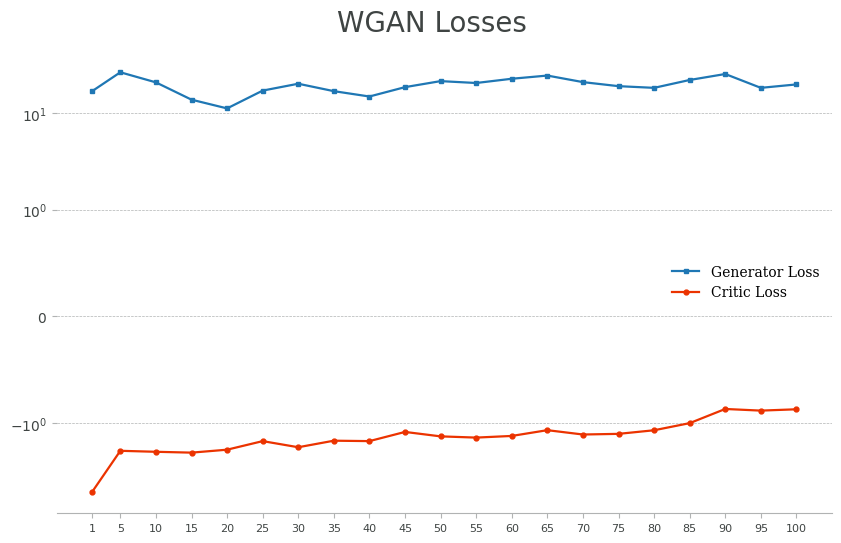

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator

epochs = 100

selected_epochs = [1] + list(range(5, epochs + 1, 5))

selected_D = [D_loss_mean[i-1] for i in selected_epochs]
selected_G = [G_loss_mean[i-1] for i in selected_epochs]

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.plot(selected_epochs, selected_G, color="#1F77B4", marker="s", markersize=3.5,
        lw=1.6, clip_on=False, label="Generator Loss")

ax.plot(selected_epochs, selected_D, color="#EB3300", marker="o", markersize=3.5,
        lw=1.6, clip_on=False, label="Critic Loss")


ax.set_yscale('symlog', linthresh=1)

# Griglia e Spines (Bordi)
ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color="#B1B3B3")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color("#B1B3B3")

ax.tick_params(axis="x", color="#B1B3B3", labelcolor="#3F4443", labelsize=8)
ax.tick_params(axis="y", color="#B1B3B3", labelcolor="#3F4443")

ax.set_xticks(selected_epochs)

ax.legend(loc="center right", frameon=False, fontsize=12, prop={"family": "serif"})

fig = plt.gcf()
fig.text(0.5, 0.95, "WGAN Losses", ha="center", va="top", fontsize=20, color="#3F4443")


plt.show()

## 3 Results:
In questa sezione vengono mostrati i due modi principali per poter valutare i risultati ottenuti. La prima immagine mostra i grafici delle due loss, in modo da monitorare l'andamento delle due reti durante il processo di training.
Successivamente sono state generate 100 immagini casualmente per poter visualizzare i risultati prodotti. Infine è stato calcolato il FID Score per poter avere una valutazione qualitativa della differenza tra le immagini generate e quelle reali del dataset MNIST.


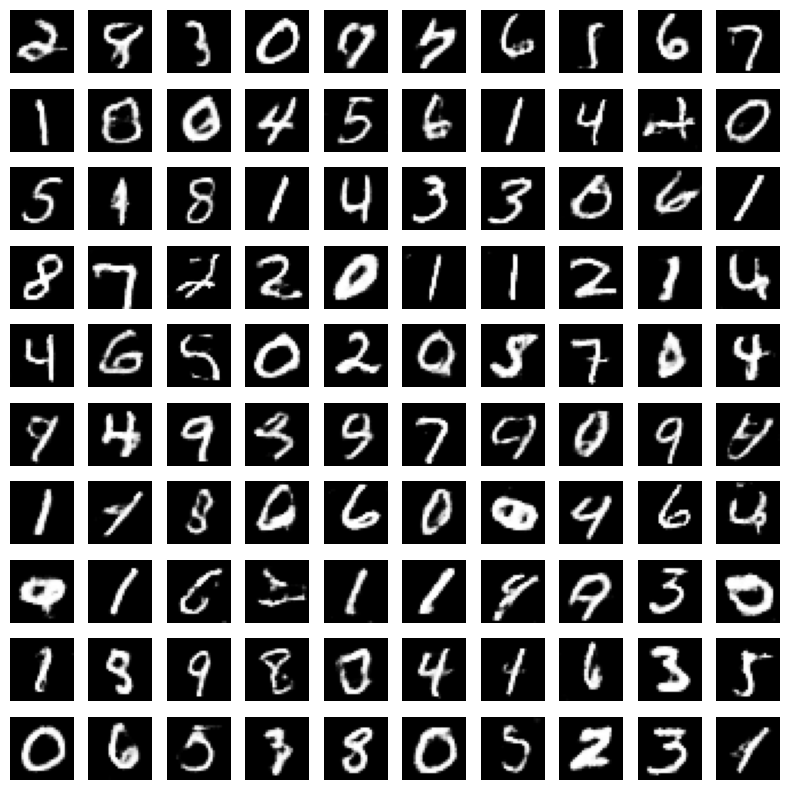

In [5]:
latent_dim = 100

def generate_and_display_images(model, num_images_to_generate):
    noise = tf.random.normal([num_images_to_generate, latent_dim])
    generated_images = model(noise, training=False)
    generated_images = (generated_images + 1) / 2.0

    grid_size = int(np.sqrt(num_images_to_generate))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

    axes = axes.flatten()

    for i in range(num_images_to_generate):
        img = generated_images[i, :, :, 0]

        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

generate_and_display_images(G, 100)

In [6]:
import numpy as np
import tensorflow as tf
from scipy.linalg import sqrtm


NUM_IMAGES_FID = 10000
BATCH_SIZE = 16
LATENT_DIM = 100

def calculate_fid_score(mu1, sigma1, mu2, sigma2):
    """Calcola il FID Score date le statistiche (media e covarianza)."""
    ssdiff = np.sum((mu1 - mu2)**2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def preprocess_image_mapping(image):

    image = (image * 127.5) + 127.5

    image = tf.image.resize(image, [299, 299], method='bilinear')

    image = tf.image.grayscale_to_rgb(image)

    image = tf.keras.applications.inception_v3.preprocess_input(image)

    return image

def get_inception_statistics(model, images_tensor, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_tensor)
    dataset = dataset.map(preprocess_image_mapping, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    act = model.predict(dataset, verbose=1)

    # Calcolo statistiche
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)

    return mu, sigma


#  Caricamento InceptionV3
print("Loading images")
inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    pooling='avg',
    input_shape=(299, 299, 3)
)

# Calcolo statistiche immagini REALI
real_subset = train_images[:NUM_IMAGES_FID]
real_subset = tf.cast(real_subset, tf.float32)
if len(real_subset.shape) == 3:
    real_subset = tf.expand_dims(real_subset, axis=-1)

mu_real, sigma_real = get_inception_statistics(inception_model, real_subset, BATCH_SIZE)

# Calcolo statistiche immagini FAKE

fake_images_list = []
num_batches = int(np.ceil(NUM_IMAGES_FID / BATCH_SIZE))

for i in range(num_batches):
    current_batch_size = min(BATCH_SIZE, NUM_IMAGES_FID - len(fake_images_list) * BATCH_SIZE)
    if current_batch_size <= 0: break

    noise = tf.random.normal([current_batch_size, LATENT_DIM])
    generated_batch = G(noise, training=False)
    fake_images_list.append(generated_batch)

fake_images_tensor = tf.concat(fake_images_list, axis=0)

mu_fake, sigma_fake = get_inception_statistics(inception_model, fake_images_tensor, BATCH_SIZE)

# Calcolo finale
fid = calculate_fid_score(mu_real, sigma_real, mu_fake, sigma_fake)

print(f"FID SCORE: {fid:.4f}")


Loading images
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step
FID SCORE: 11.8961



## 4 Estensione al Dominio Finanziario: Dai Pattern Spaziali alla Dinamica Stocastica

Validata la robustezza e la capacità di convergenza della WGAN-GP su un manifold topologicamente strutturato quale quello delle immagini, il progetto estende l'applicazione del modello alla generazione di serie temporali finanziarie. A differenza del dominio visivo, caratterizzato da forti correlazioni spaziali locali, i dati di mercato presentano sfide peculiari legate alla natura stocastica del segnale, alla non stazionarietà e alla presenza di eventi estremi.

L'obiettivo di questa fase è adattare l'architettura per modellare la distribuzione di probabilità sottostante ai rendimenti dell'indice S&P 500. La generazione di dati sintetici fedeli, in questo contesto, non serve a scopi predittivi, bensì a fornire scenari alternativi statisticamente consistenti per applicazioni di *Risk Management* e *Stress Testing*, superando i limiti della limitata disponibilità di dati storici.

## 4.1 Implementazione e Preparazione del Dataset Finanziario

Per l'addestramento del modello sono stati utilizzati i dati storici dell'indice S&P 500, acquisiti tramite le API di Yahoo Finance. L'arco temporale selezionato copre il periodo dal 1° Gennaio 2000 al 31 Dicembre 2023, includendo diverse fasi di mercato come bull market, bear market e crisi sistemiche per garantire una rappresentatività statistica adeguata.

Poiché i prezzi grezzi di un asset finanziario non sono stazionari, il dataset è stato trasformato in rendimenti logaritmici, calcolati come:

$$ r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) $$

dove $P_t$ rappresenta il prezzo di chiusura al tempo $t$. Questa trasformazione è standard in finanza quantitativa poiché stabilizza la media e rende la varianza più trattabile per le reti neurali.

Per preservare la dipendenza temporale necessaria all'apprendimento delle correlazioni seriali, i dati non sono stati forniti alla rete come singoli punti, ma strutturati in sequenze temporali tramite una finestra mobile. È stata definita una lunghezza di sequenza pari a 60 giorni con uno passo di avanzamento unitario. Questo approccio trasforma la serie storica in un insieme di vettori, dove ogni campione rappresenta l'evoluzione del mercato negli ultimi tre mesi di trading circa.

Infine, per garantire la compatibilità con la funzione di attivazione *Tanh* del generatore, le sequenze sono state normalizzate nell'intervallo $[-1, 1]$ utilizzando una trasformazione Min-Max globale calcolata sull'intero dataset di training.


In [7]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import pandas as pd

tf.random.set_seed(16)
np.random.seed(16)
random.seed(16)
try:
    dataframe = yf.download('^GSPC', start='2000-01-01', end='2023-12-31', progress=False)
    print("download done")
except Exception as e:
    print(f"error during download: {e}")
    exit()

log_returns=np.log(dataframe['Close']/dataframe['Close'].shift(1)).dropna()

data = log_returns.values
print(f"\nloaded {len(data)} data.")

sequence_lenth=60
step_size=1
dataset_list=[]

for i in range(0,len(data)-sequence_lenth+step_size):
    x=[]
    for j in range(sequence_lenth):
        x.append(data[j+i])
    dataset_list.append(x)

dataset = np.array(dataset_list)
dataset = np.reshape(dataset, (-1, 60, 1))

min_val = dataset.min()
max_val = dataset.max()
print("min =" + str(min_val)+" max = " + str(max_val))

dataset=2*(dataset-min_val)/(max_val-min_val)-1  #data normalization with center in zero
train_sequence = dataset.astype('float32')


/tmp/ipython-input-2532376612.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dataframe = yf.download('^GSPC', start='2000-01-01', end='2023-12-31', progress=False)


download done

loaded 6036 data.
min =-0.12765219747281742 max = 0.10957196759533848


## 4.2 Architettura
La transizione dal dominio visivo a quello finanziario ha imposto una sostanziale revisione strutturale del modello, sostituendo le convoluzioni bidimensionali, ottimali per le correlazioni spaziali dei pixel, con operatori monodimensionali (1D) specifici per catturare le dipendenze sequenziali e i pattern di autocorrelazione temporale.

Il Generatore opera proiettando il vettore latente $z$ in uno spazio iniziale a bassa risoluzione temporale, per poi espanderlo progressivamente attraverso strati di Convoluzione Trasposta 1D. Questo processo di *upsampling* incrementa la lunghezza della sequenza ad ogni passaggio, trasformando il rumore gaussiano in una traiettoria di prezzo coerente di 60 step temporali, normalizzata infine dalla funzione tangente iperbolica.

Specularmente, il Critico è stato progettato per agire come un estrattore di feature temporali, comprimendo la sequenza di input attraverso filtri convoluzionali che riducono la dimensionalità aumentando al contempo la profondità delle mappe caratteristiche. Rispetto alla controparte utilizzata su MNIST, questa architettura introduce uno strato denso intermedio dotato di regolarizzazione Dropout prima dell'output lineare finale, una scelta mirata a catturare con maggiore efficacia le complesse non-linearità e la volatilità intrinseca dei dati di mercato prima di calcolare la stima della distanza di Wasserstein.


In [8]:

G=tf.keras.Sequential([
    tf.keras.layers.Dense(units=1500,input_shape=(100,)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((15,100)),
    tf.keras.layers.Conv1DTranspose(filters=256,kernel_size=3,padding="same",strides=2),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv1DTranspose(filters=1,kernel_size=3,activation="tanh",padding="same",strides=2),
])

G.summary()

D=tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128,kernel_size=3,padding="same",strides=2,input_shape=(60,1)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv1D(filters=256,kernel_size=3,padding="same",strides=2),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256,activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1)
])

D.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1500)           │       151,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 30, 256)        │        77,056 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 60, 1)          │           769 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,325 (895.80 KB)

 Trainable params: 229,325 (895.80 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       983,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,082,625 (4.13 MB)

 Trainable params: 1,082,625 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from scipy.linalg import sqrtm

GP_WEIGHT=10.0 # Standard value for the Gradient Penalty weight
batch_size=256
epochs=100
latent_dim=100
D_loss_mean=[]
G_loss_mean=[]
D_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5,clipvalue=0.01)
G_optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001, beta_1=0.5,clipvalue=0.01)
dataset_tf=tf.data.Dataset.from_tensor_slices(train_sequence).shuffle(len(train_sequence)).batch(batch_size,drop_remainder=True)

@tf.function
def train_critic_step(real_sequence):
    batch_size = tf.shape(real_sequence)[0]
    noise = tf.random.normal(shape=(batch_size, latent_dim))

    with tf.GradientTape() as disc_tape:
        fake_sequence = G(noise, training=True)
        real_output = D(real_sequence, training=True)
        fake_output = D(fake_sequence, training=True)

        # Loss WGAN e Gradient Penalty (identici a prima)
        disc_wgan_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
        alpha = tf.random.uniform(shape=[batch_size, 1, 1], minval=0., maxval=1.)
        interpolated_sequence = alpha * real_sequence + (1 - alpha) * fake_sequence
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_sequence)
            pred = D(interpolated_sequence, training=True)
        grads = gp_tape.gradient(pred, [interpolated_sequence])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
        disc_loss = disc_wgan_loss + GP_WEIGHT * gradient_penalty

    D_Gradient = disc_tape.gradient(disc_loss, D.trainable_variables)
    D_optimizer.apply_gradients(zip(D_Gradient, D.trainable_variables))
    return disc_loss

@tf.function
def train_generator_step(batch_size):
    noise = tf.random.normal(shape=(batch_size, latent_dim))
    with tf.GradientTape() as gen_tape:
        fake_sequence = G(noise, training=True)
        fake_output = D(fake_sequence, training=True)
        gen_loss = -tf.reduce_mean(fake_output)

    G_Gradient = gen_tape.gradient(gen_loss, G.trainable_variables)
    G_optimizer.apply_gradients(zip(G_Gradient, G.trainable_variables))
    return gen_loss

n_critic = 5

for epoch in range(epochs):
    epoch_d_loss = []
    epoch_g_loss = []

    # Usiamo un contatore per decidere quando aggiornare G
    for step, sequence_batch in enumerate(dataset_tf):

        # 1. Il Critico viene aggiornato ad OGNI step
        d_loss = train_critic_step(sequence_batch)
        epoch_d_loss.append(d_loss.numpy())

        # 2. Il Generatore viene aggiornato solo ogni n_critic steps
        if step % n_critic == 0:
            g_loss = train_generator_step(batch_size)
            epoch_g_loss.append(g_loss.numpy())

    # Calcolo delle medie per le statistiche dell'epoca
    avg_d = np.mean(epoch_d_loss)
    # G potrebbe avere meno campioni nel log, np.mean gestisce tutto correttamente
    avg_g = np.mean(epoch_g_loss) if len(epoch_g_loss) > 0 else 0

    D_loss_mean.append(avg_d)
    G_loss_mean.append(avg_g)

    print(f"Epoch {epoch + 1}/{epochs} - D Loss: {avg_d:.4f}, G Loss: {avg_g:.4f}")

    avg_d=np.mean(epoch_d_loss)
    avg_g=np.mean(epoch_g_loss)

    D_loss_mean.append(avg_d)
    G_loss_mean.append(avg_g)

    print(f"Epoch {epoch + 1}/{epochs} - D Loss: {avg_d:.4f}, G Loss: {avg_g:.4f}")




Epoch 1/100 - D Loss: 7.8498, G Loss: 0.0004
Epoch 1/100 - D Loss: 7.8498, G Loss: 0.0004
Epoch 2/100 - D Loss: 6.9804, G Loss: 0.0004
Epoch 2/100 - D Loss: 6.9804, G Loss: 0.0004
Epoch 3/100 - D Loss: 5.9626, G Loss: 0.0009
Epoch 3/100 - D Loss: 5.9626, G Loss: 0.0009
Epoch 4/100 - D Loss: 4.8873, G Loss: -0.0000
Epoch 4/100 - D Loss: 4.8873, G Loss: -0.0000
Epoch 5/100 - D Loss: 3.8288, G Loss: -0.0017
Epoch 5/100 - D Loss: 3.8288, G Loss: -0.0017
Epoch 6/100 - D Loss: 2.8268, G Loss: -0.0043
Epoch 6/100 - D Loss: 2.8268, G Loss: -0.0043
Epoch 7/100 - D Loss: 1.8773, G Loss: -0.0059
Epoch 7/100 - D Loss: 1.8773, G Loss: -0.0059
Epoch 8/100 - D Loss: 1.1291, G Loss: -0.0059
Epoch 8/100 - D Loss: 1.1291, G Loss: -0.0059
Epoch 9/100 - D Loss: 0.5713, G Loss: -0.0095
Epoch 9/100 - D Loss: 0.5713, G Loss: -0.0095
Epoch 10/100 - D Loss: 0.2289, G Loss: -0.0117
Epoch 10/100 - D Loss: 0.2289, G Loss: -0.0117
Epoch 11/100 - D Loss: 0.1052, G Loss: -0.0140
Epoch 11/100 - D Loss: 0.1052, G Loss

## 5 Risultati:
 In questa sezione vengono presentati gli esiti sperimentali dell'addestramento. L'analisi inizia con la valutazione della stabilità del training attraverso le curve di loss del Generatore e del Critico, seguita da un confronto qualitativo tra una sequenza temporale sintetica e una reale. Infine, viene esaminata la fedeltà statistica del modello attraverso l'analisi delle distribuzioni di probabilità: tale confronto è stato effettuato su un dataset esteso di 5.000 campioni generati e viene visualizzato sia in scala lineare che logaritmica per evidenziare il comportamento sulle code.


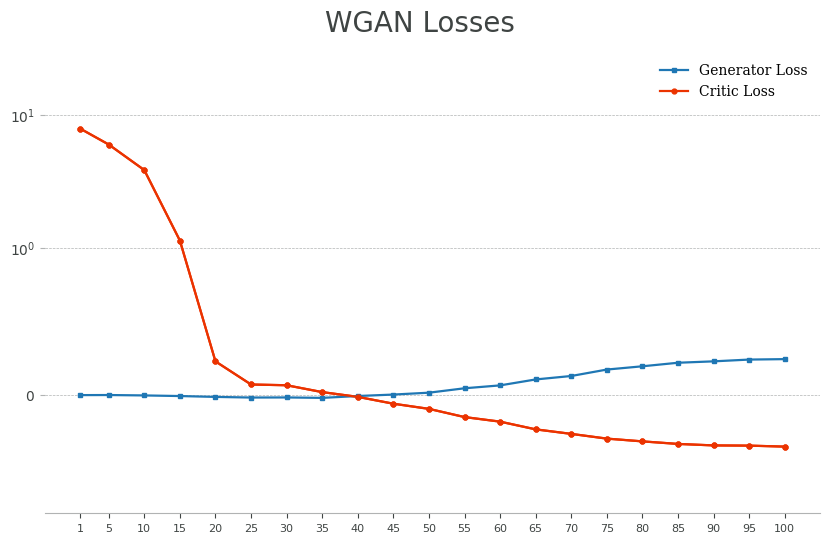

In [10]:
#plot of G and L mean loss for all epochs
from matplotlib.ticker import MultipleLocator, FixedLocator

plt.figure(figsize=(10,6))
xvalues=[1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
D_plot=[]
G_plot=[]
for el in xvalues:
    D_plot.append(D_loss_mean[el-1])
    G_plot.append(G_loss_mean[el-1])

ax=plt.gca()
ax.set_ylim(-0.8, 30)
ax.plot(xvalues,D_plot,color="#EB3300", marker="o",markersize=3.5,lw=1.6,clip_on=False)
ax.yaxis.grid(True,linestyle="--",linewidth=0.5,color="#B1B3B3")
ax.set_yscale('symlog', linthresh=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color("#B1B3B3")
ax.tick_params(axis="x",color="#B1B3B3",labelcolor="#3F4443")
ax.tick_params(axis="y",color="#B1B3B3",labelcolor="#3F4443")
ax.xaxis.label.set_color("#B1B3B3")

ticks = [1] + list(range(5, 101, 5))

ax.set_xticks(ticks)  # fisso i tick dove voglio
ax.tick_params(axis='x', labelsize=8, colors="#3F4443")  # stile professionale

ax.plot(xvalues, G_plot, color="#1F77B4", marker="s", markersize=3.5,
        lw=1.6, clip_on=False, label="Generator Loss")

# Aggiorna la legenda
ax.plot(xvalues, D_plot, color="#EB3300", marker="o", markersize=3.5,
        lw=1.6, clip_on=False, label="Critic Loss")

ax.legend(loc="upper right",frameon=False,fontsize=12,prop={"family":"serif"})


fig=plt.gcf()
fig.text(0.5,0.95,"WGAN Losses",ha="center",va="top",fontsize=20,color="#3F4443")
plt.show()


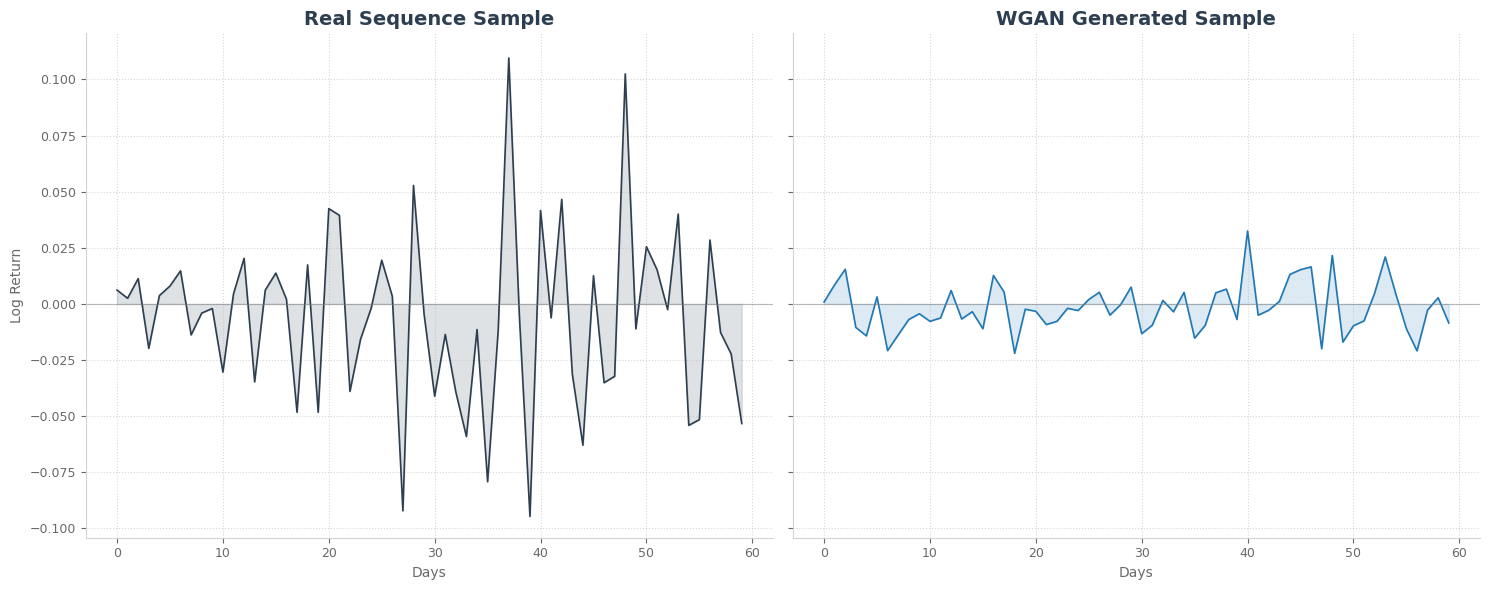

In [11]:
# 1. Generazione dato Finto
noise = tf.random.normal(shape=(1, latent_dim))
generated_sequence_normalized = G(noise, training=False).numpy().squeeze()
# De-normalizzazione dato finto (usando min_val e max_val)
generated_sequence_real = ((generated_sequence_normalized + 1) * (max_val - min_val) / 2) + min_val

# 2. Selezione dato Reale (Definiamo prima l'indice, poi lo usiamo)
real_sample_index = np.random.randint(0, len(train_sequence))
real_sequence_normalized = train_sequence[real_sample_index].squeeze()
# De-normalizzazione dato reale
real_sequence_real = ((real_sequence_normalized + 1) * (max_val - min_val) / 2) + min_val

# 3. Calcolo limiti Y (usando np.minimum/maximum per sicurezza)
y_min = np.minimum(real_sequence_real.min(), generated_sequence_real.min()) * 1.1
y_max = np.maximum(real_sequence_real.max(), generated_sequence_real.max()) * 1.1

# 4. Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Grafico Reale
ax1.plot(real_sequence_real, color='#2c3e50', linewidth=1.2)
ax1.fill_between(range(len(real_sequence_real)), real_sequence_real, color='#2c3e50', alpha=0.15)
ax1.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax1.set_title('Real Sequence Sample', fontsize=14, fontweight='bold', color='#2c3e50')
ax1.set_xlabel('Days', fontsize=10, color='dimgray')
ax1.set_ylabel('Log Return', fontsize=10, color='dimgray')
ax1.set_ylim(y_min, y_max)

# Grafico Generato
ax2.plot(generated_sequence_real, color='#1f77b4', linewidth=1.2)
ax2.fill_between(range(len(generated_sequence_real)), generated_sequence_real, color='#1f77b4', alpha=0.15)
ax2.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax2.set_title('WGAN Generated Sample', fontsize=14, fontweight='bold',color='#2c3e50')
ax2.set_xlabel('Days', fontsize=10, color='dimgray')

for ax in [ax1, ax2]:
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('lightgray')
    ax.spines['bottom'].set_color('lightgray')
    ax.tick_params(axis='both', colors='dimgray', labelsize=9)

plt.tight_layout()
plt.show()

In [12]:

from tqdm import tqdm
import pandas as pd


NUM_SAMPLES = 5000  # Numero di sequenze da generare

all_generated_sequences = []

print(f"Generazione di {NUM_SAMPLES} campioni dal Generatore...")
for _ in tqdm(range(NUM_SAMPLES)):

    noise = tf.random.normal(shape=(1, latent_dim))         # Crea rumore casuale
    # Genera una sequenza normalizzata
    generated_sequence_normalized = G(noise, training=False)

    all_generated_sequences.append(generated_sequence_normalized.numpy())       # Aggiunge la sequenza alla lista


# Concatena tutte le sequenze in un unico grande array NumPy
generated_dataset_normalized = np.concatenate(all_generated_sequences)

generated_dataset_real=((generated_dataset_normalized+1)*(max_val-min_val)/2)+min_val    # denormalizzazione

# Appiattisce l'array per ottenere una singola serie di rendimenti giornalieri

generated_returns_flat = generated_dataset_real.flatten()

print(f"Mean:  {np.mean(data):.6f}  |   {np.mean(generated_returns_flat):.6f}")
print(f"Standard Deviation:{np.std(data):.6f}  |   {np.std(generated_returns_flat):.6f}")
print(f"Excess Kurtosis: {pd.Series(data.flatten()).kurtosis():.6f}  |   {pd.Series(generated_returns_flat).kurtosis():.6f}")


Generazione di 5000 campioni dal Generatore...


100%|██████████| 5000/5000 [00:44<00:00, 113.08it/s]

Mean:  0.000197  |   -0.002194
Standard Deviation:0.012379  |   0.010593
Excess Kurtosis: 10.283440  |   0.107423


| Statistic            | Real     | Generated     |
|----------------------|------------|------------|
| Mean                 | 0.000197   | -0.002194  |
| Standard Deviation   | 0.012379   | 0.010593   |
| Excess Kurtosis      | 10.283440  | 0.107427   |


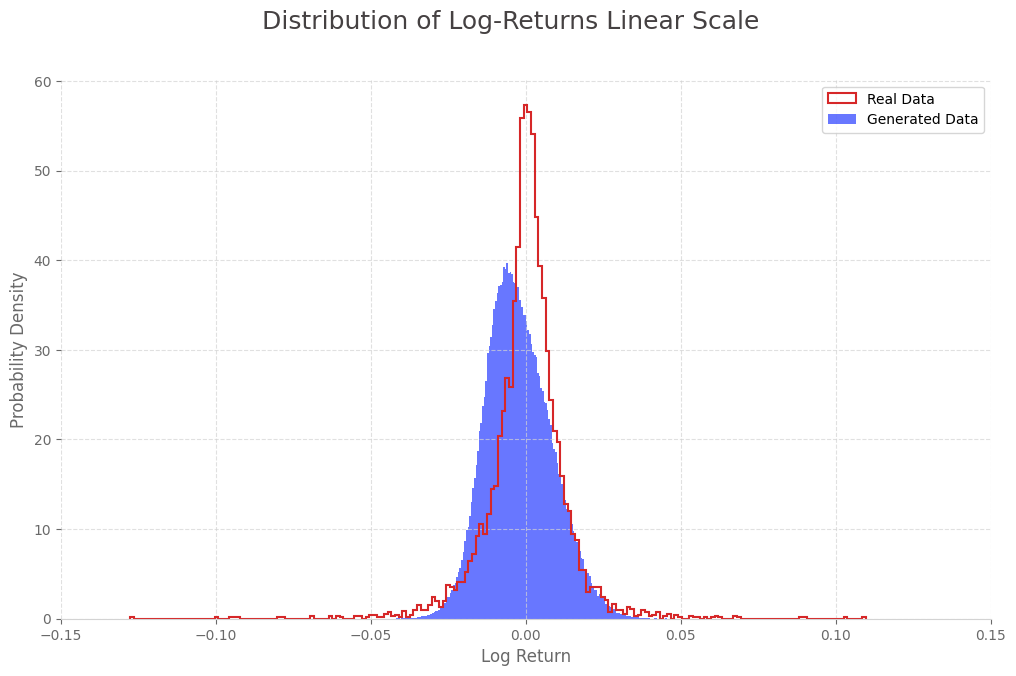

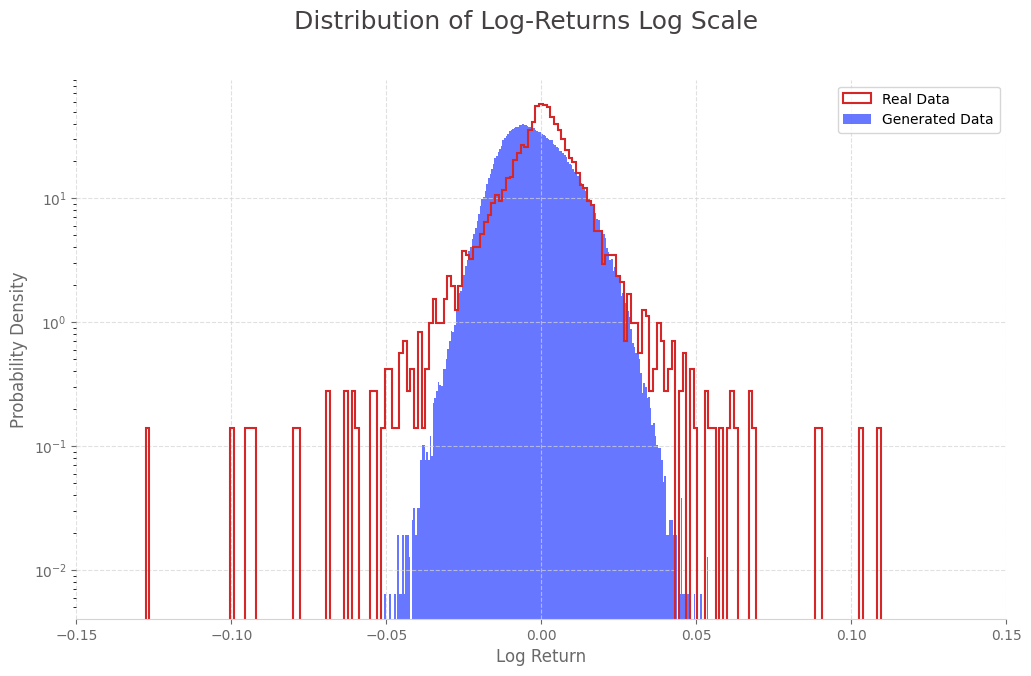

In [13]:
#linear scale
fig, ax = plt.subplots(figsize=(12, 7))

ax.hist(data, bins=200, density=True, label='Real Data',
        color='#d62728', histtype='step', linewidth=1.5)

ax.hist(generated_returns_flat, bins=200, density=True, label='Generated Data',
        color="#041DFF", alpha=0.6)

fig.suptitle('Distribution of Log-Returns Linear Scale', fontsize=18,color="#454142")

ax.set_xlabel('Log Return', fontsize=12, color='dimgray')
ax.set_ylabel('Probability Density', fontsize=12, color='dimgray')
ax.grid(True, linestyle='--', color='lightgray', alpha=0.7)
ax.set_xlim(-0.15,0.15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('lightgray')

ax.tick_params(axis='x', colors='dimgray')
ax.tick_params(axis='y', colors='dimgray')

legend = ax.legend(frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.8)

plt.show()

# log scale
fig, ax = plt.subplots(figsize=(12, 7))

ax.hist(data, bins=200, density=True, label='Real Data',
        color='#d62728', histtype='step', linewidth=1.5)

ax.hist(generated_returns_flat, bins=200, density=True, label='Generated Data',
        color="#041DFF", alpha=0.6)

fig.suptitle('Distribution of Log-Returns Log Scale', fontsize=18,color="#454142")

ax.set_xlabel('Log Return', fontsize=12, color='dimgray')
ax.set_ylabel('Probability Density', fontsize=12, color='dimgray')
ax.grid(True, linestyle='--', color='lightgray', alpha=0.7)
ax.set_yscale('log')
ax.set_xlim(-0.15,0.15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('lightgray')

ax.tick_params(axis='x', colors='dimgray')
ax.tick_params(axis='y', colors='dimgray')

legend = ax.legend(frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.8)

## 6 Discussioni:
###MNIST
L'analisi delle curve di apprendimento sul dataset MNIST evidenzia la stabilità dinamica introdotta dalla formulazione WGAN-GP. Osservando l'andamento della funzione di costo, si nota come la Loss del Critico converga progressivamente da valori negativi verso lo zero. In termini fisici, questo comportamento indica una riduzione monotona della stima della distanza di Wasserstein tra la distribuzione reale e quella generata, confermando che il sistema ha appreso efficacemente la topologia dei dati senza incorrere in fenomeni di divergenza.

Parallelamente, la Loss del Generatore mostra le tipiche oscillazioni, ma si mantiene limitata entro un intervallo stabile. L'assenza di picchi improvvisi  è un indicatore diretto dell'efficacia della Gradient Penalty, che ha impedito l'esplosione del gradiente mantenendo i pesi della rete all'interno del vincolo di Lipschitzianità.

Dal punto di vista quantitativo, il FID Score ottenuto di 10.81 conferma che la distanza statistica tra le due distribuzioni è minima, suggerendo un'elevata qualità della generazione e l'assenza di Mode Collapse, ovvero il modello non genera sempre la stessa cifra, ma varia. Infine, l'ispezione visiva dei campioni sintetici dimostra che la rete ha codificato correttamente le caratteristiche spaziali dei numeri, producendo cifre nitide e morfologicamente coerenti con il dataset di training, pur mantenendo una certa variabilità che denota capacità di generalizzazione e non semplice memorizzazione.

### Finacial

Le curve di apprendimento relative al dataset finanziario mostrano una dinamica iniziale distinta rispetto al caso MNIST, riflettendo la maggiore entropia e la natura non stazionaria dei rendimenti di mercato rispetto alla topologia definita delle immagini. Nonostante questa complessità intrinseca, il modello raggiunge un regime di equilibrio asintotico analogo: la Loss del Critico converge stabilmente verso valori negativi prossimi allo zero, mentre quella del Generatore si assesta su valori positivi. La ridotta volatilità delle curve di loss conferma che, anche in presenza di dati rumorosi, il vincolo della Gradient Penalty ha prevenuto efficacemente fenomeni di divergenza.

L'analisi quantitativa, condotta sui momenti statistici di 5.000 campioni sintetici, evidenzia una dicotomia nelle prestazioni del modello. Il Generatore ha appreso con eccellente precisione il primo e il secondo momento, dimostrando di aver catturato correttamente i valori statistici fondamentali.

Tuttavia, il confronto sul quarto momento, ovvero l'Eccesso di Curtosi rivela una discrepanza significativa: la distribuzione generata tende ad essere simile a una Gaussiana, sottostimando gli eventi estremi tipici dei mercati finanziari (reale $\approx 10.28$ vs generata $\approx 0.10$). Tale limitazione è strutturale ed è riconducibile all'assunzione a priori sullo spazio latente: l'utilizzo di un vettore di input $z$ campionato da una distribuzione Normale Standard $\mathcal{N}(0,1)$ impone al Generatore un bias verso la normalità che risulta complesso da rompere per approssimare le code pesanti della distribuzione empirica.

## 7 Conclusioni:

Il presente lavoro ha confermato l'efficacia dell'architettura WGAN-GP come framework stabile per modelli generativi in domini complessi. La fase di validazione su MNIST ha dimostrato la capacità del modello di apprendere correttamente la topologia dei dati, garantendo una convergenza del gradiente priva delle instabilità tipiche delle GAN classiche.

L'estensione alla dinamica stocastica dell'S&P 500 ha prodotto risultati promettenti ma strutturalmente eterogenei: se da un lato il generatore ha replicato fedelmente la componente diffusiva e i regimi di volatilità, dall'altro ha evidenziato limiti nella modellazione degli eventi estremi. La significativa discrepanza sulla Curtosi indica che l'utilizzo di uno spazio latente gaussiano costituisce un bias troppo forte per rappresentare naturalmente le code dei mercati.

In definitiva, il modello proposto si qualifica come un valido simulatore per scenari di mercato in regime ordinario. Tuttavia, per applicazioni avanzate sugli eventi di coda, sviluppi futuri dovranno necessariamente orientarsi verso l'iniezione di rumore a distribuzione pesante come Lévy o t-Student direttamente nello spazio latente, per rompere la simmetria gaussiana appresa dal generatore.


## 8 Referenze:
[1] Abadi, M., et al. (2016). TensorFlow: A system for large-scale machine learning. In 12th USENIX Symposium on Operating Systems Design and Implementation (OSDI 16) (pp. 265–283).

[2] Harris, C. R., Millman, K. J., van der Walt, S. J., et al. (2020). Array programming with NumPy. Nature, 585, 357–362.

[3] LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278–2324.

[4] Chollet, F., et al. (2015). Keras. Software available from keras.io.

[5] Gulrajani, I., Ahmed, F., Arjovsky, M., Dumoulin, V., & Courville, A. (2017). Improved training of Wasserstein GANs. Advances in Neural Information Processing Systems, 30.